In [2]:
import pywt
import numpy as np
import mne
from mne.datasets import eegbci


In [9]:
# Load EEG signal using MNE (example for raw data)

# Download EEGBCI dataset
eegbci_files = eegbci.load_data(subject=1, runs=[1])

# Get the path to the EEGBCI dataset
eegbci_path = eegbci_files[0]

# Load the raw EEG data file
raw = mne.io.read_raw_edf(eegbci_path, preload=True)

raw.plot()



Extracting EDF parameters from C:\Users\Ricca\mne_data\MNE-eegbci-data\files\eegmmidb\1.0.0\S001\S001R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Using qt as 2D backend.


<mne_qt_browser._pg_figure.MNEQtBrowser(0x181b9a39390) at 0x00000181BB347740>

In [10]:
eeg_channel = 'Fc6.'  # Example EEG channel (replace with your channel name)

# Get data for the selected channel
eeg_signal, times = raw.get_data(picks=eeg_channel, return_times=True)
eeg_signal = eeg_signal[0]  # Extract the signal array

# Choose wavelet and decomposition level
wavelet = 'db4'
level = 4

# Perform wavelet decomposition
coeffs = pywt.wavedec(eeg_signal, wavelet, level=level)



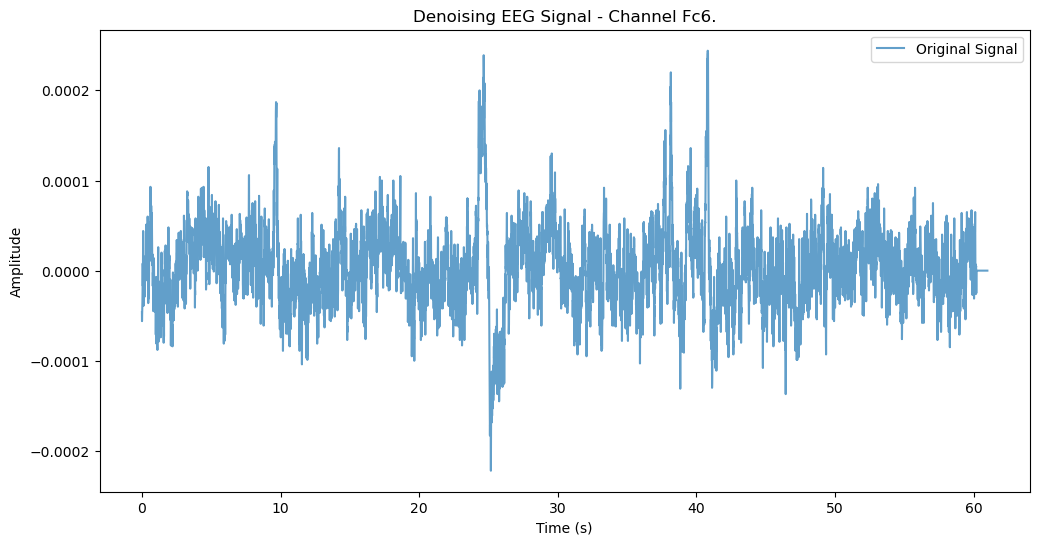

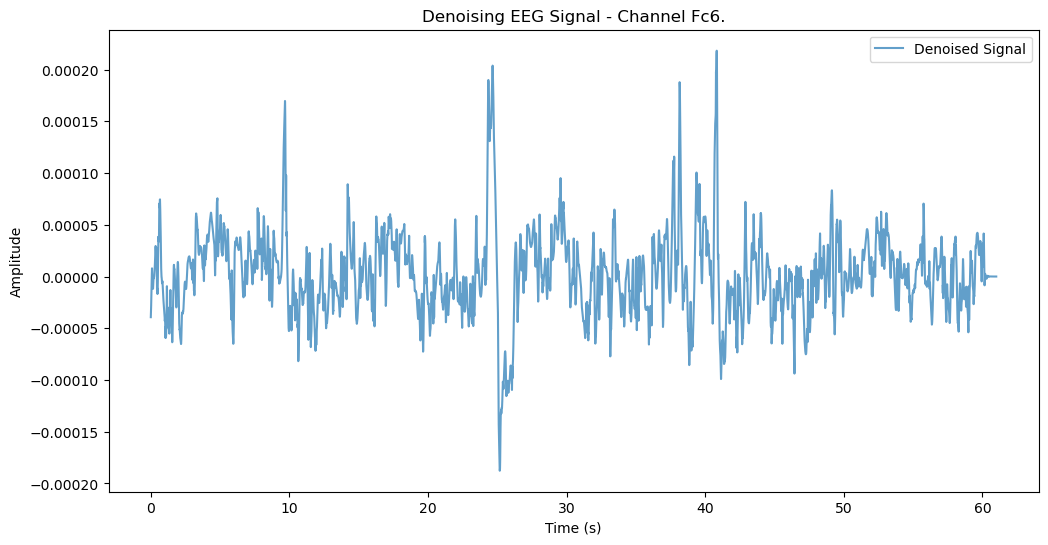

In [12]:
# Estimate noise sigma from detail coefficients at level 1
sigma = np.median(np.abs(coeffs[-1])) / 0.6745

# Define universal threshold
threshold = sigma * np.sqrt(2 * np.log(len(eeg_signal)))

# Apply soft thresholding to detail coefficients
thresholded_coeffs = [coeffs[0]]  # Approximation coefficients remain unchanged
thresholded_coeffs += [pywt.threshold(c, threshold, mode='soft') for c in coeffs[1:]]

# Reconstruct the denoised signal
denoised_eeg = pywt.waverec(thresholded_coeffs, wavelet)

# Plot original and denoised signals using MNE for comparison
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(times, eeg_signal, label='Original Signal', alpha=0.7)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.title(f'Denoising EEG Signal - Channel {eeg_channel}')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(times[:len(denoised_eeg)], denoised_eeg, label='Denoised Signal', alpha=0.7)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.title(f'Denoising EEG Signal - Channel {eeg_channel}')
plt.show()

In [15]:
# Calculate Mean Squared Error (MSE)
mse = np.mean((eeg_signal[:len(denoised_eeg)] - denoised_eeg) ** 2)
print(mse)

# Calculate Signal-to-Noise Ratio (SNR)
signal_power = np.mean(eeg_signal ** 2)
noise_power = np.mean((eeg_signal[:len(denoised_eeg)] - denoised_eeg) ** 2)
snr = 10 * np.log10(signal_power / noise_power)
print(snr)



2.682791301180141e-10
8.670166630009573
